In [2]:
pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00


In [3]:
import os
import requests
import xarray as xr
from tqdm import tqdm
import pandas as pd
import cftime

BASE_URL = "https://www.ncei.noaa.gov/data/oceans/woa/WOA23/DATA/"

FILES = {
    "Temperature": "temperature/netcdf/decav91C0/1.00/woa23_decav91C0_t{month}_01.nc",
    "Salinity": "salinity/netcdf/decav91C0/1.00/woa23_decav91C0_s{month}_01.nc",
    "Oxygen": "oxygen/netcdf/all/1.00/woa23_all_o{month}_01.nc",
    "Nitrate": "nitrate/netcdf/all/1.00/woa23_all_n{month}_01.nc",
    "Phosphate": "phosphate/netcdf/all/1.00/woa23_all_p{month}_01.nc"
}

def download_file(url, filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total_size = int(response.headers.get('content-length', 0))
    with open(filename, 'wb') as f, tqdm(
        desc=os.path.basename(filename),
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for chunk in response.iter_content(8192):
            f.write(chunk)
            pbar.update(len(chunk))

def decode_time(ds):
    time_var = ds.time
    units = time_var.attrs.get('units', '')
    calendar = time_var.attrs.get('calendar', 'standard')

    if units.startswith("months since"):
        calendar = '360_day'

    times = cftime.num2date(time_var.values, units=units, calendar=calendar)
    # Konwertujemy do pandas datetime (na 1-szy dzień miesiąca)
    times_pd = pd.to_datetime([f"{t.year}-{t.month:02d}-01" for t in times])
    ds['time'] = ('time', times_pd)
    return ds


os.makedirs("WOA23_monthly", exist_ok=True)

for month in range(1, 13):
    month_str = f"{month:02d}"
    print(f"\n=== Month {month_str} ===")

    for var, template in FILES.items():
        filepath = template.format(month=month_str)
        url = BASE_URL + filepath
        filename = os.path.join("WOA23_monthly", os.path.basename(filepath))

        if not os.path.exists(filename):
            print(f"Downloading {var}...")
            download_file(url, filename)

        ds = xr.open_dataset(filename, decode_times=False)
        ds = decode_time(ds)

        var_name = {
            "Temperature": "t_an",
            "Salinity": "s_an",
            "Oxygen": "o_an",
            "Nitrate": "n_an",
            "Phosphate": "p_an"
        }[var]

        print(f"\n{var} (Month {month_str}):")
        print("Variables:", list(ds.variables.keys()))

        df = ds[var_name].to_dataframe().dropna()
        print(f"Data without NaNs ({len(df)} rows):")
        print(df)

print("\nAll monthly data processed!")



=== Month 01 ===


woa23_decav91C0_t01_01.nc: 100%|██████████| 57.0M/57.0M [00:38<00:00, 1.55MB/s]



Temperature (Month 01):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-01-01 0.0    -77.5 -178.5 -0.32070
                        -177.5 -0.36500
                        -176.5 -0.40521
                        -175.5 -0.42581
                        -174.5 -0.44261
...                                 ...
           1500.0  89.5  175.5 -0.48721
                         176.5 -0.48721
                         177.5 -0.48721
                         178.5 -0.48721
                         179.5 -0.48721

[2183675 rows x 1 columns]


woa23_decav91C0_s01_01.nc: 100%|██████████| 50.8M/50.8M [00:00<00:00, 99.4MB/s]



Salinity (Month 01):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-01-01 0.0    -77.5 -178.5  34.200310
                        -177.5  34.186913
                        -176.5  34.175400
                        -175.5  34.168610
                        -174.5  34.157711
...                                   ...
           1500.0  89.5  175.5  34.925499
                         176.5  34.925499
                         177.5  34.925499
                         178.5  34.925499
                         179.5  34.925499

[2183675 rows x 1 columns]


woa23_all_o01_01.nc: 100%|██████████| 33.4M/33.4M [00:00<00:00, 88.0MB/s]



Oxygen (Month 01):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-01-01 0.0    -77.5 -178.5  380.476715
                        -177.5  378.862640
                        -176.5  377.417480
                        -175.5  376.051453
                        -174.5  374.945251
...                                    ...
           1500.0  89.5  175.5  287.593323
                         176.5  287.593323
                         177.5  287.593323
                         178.5  287.593323
                         179.5  287.593323

[2183675 rows x 1 columns]


woa23_all_n01_01.nc: 100%|██████████| 19.2M/19.2M [00:00<00:00, 70.7MB/s]



Nitrate (Month 01):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-01-01 0.0   -77.5 -178.5  13.159919
                       -177.5  14.001830
                       -176.5  14.797913
                       -175.5  15.565681
                       -174.5  16.184637
...                                  ...
           800.0  89.5  175.5  12.869218
                        176.5  12.869218
                        177.5  12.869218
                        178.5  12.869218
                        179.5  12.869218

[1680367 rows x 1 columns]


woa23_all_p01_01.nc: 100%|██████████| 21.1M/21.1M [00:00<00:00, 67.4MB/s]



Phosphate (Month 01):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-01-01 0.0   -77.5 -178.5  1.229126
                       -177.5  1.240432
                       -176.5  1.252754
                       -175.5  1.263371
                       -174.5  1.271232
...                                 ...
           800.0  89.5  175.5  0.890293
                        176.5  0.890293
                        177.5  0.890293
                        178.5  0.890293
                        179.5  0.890293

[1680367 rows x 1 columns]

=== Month 02 ===


woa23_decav91C0_t02_01.nc: 100%|██████████| 57.3M/57.3M [00:00<00:00, 114MB/s]



Temperature (Month 02):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-02-01 0.0    -77.5 -178.5 -0.63171
                        -177.5 -0.66981
                        -176.5 -0.70131
                        -175.5 -0.72431
                        -174.5 -0.74401
...                                 ...
           1500.0  89.5  175.5 -0.45891
                         176.5 -0.45891
                         177.5 -0.45891
                         178.5 -0.45891
                         179.5 -0.45891

[2183675 rows x 1 columns]


woa23_decav91C0_s02_01.nc: 100%|██████████| 50.8M/50.8M [00:00<00:00, 111MB/s]



Salinity (Month 02):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-02-01 0.0    -77.5 -178.5  34.116413
                        -177.5  34.096901
                        -176.5  34.078289
                        -175.5  34.063110
                        -174.5  34.050900
...                                   ...
           1500.0  89.5  175.5  34.928612
                         176.5  34.928612
                         177.5  34.928612
                         178.5  34.928612
                         179.5  34.928612

[2183675 rows x 1 columns]


woa23_all_o02_01.nc: 100%|██████████| 34.1M/34.1M [00:00<00:00, 63.5MB/s]



Oxygen (Month 02):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-02-01 0.0    -77.5 -178.5  360.776550
                        -177.5  360.950531
                        -176.5  360.977112
                        -175.5  360.972870
                        -174.5  360.920258
...                                    ...
           1500.0  89.5  175.5  288.697754
                         176.5  288.697754
                         177.5  288.697754
                         178.5  288.697754
                         179.5  288.697754

[2183675 rows x 1 columns]


woa23_all_n02_01.nc: 100%|██████████| 19.7M/19.7M [00:00<00:00, 78.1MB/s]



Nitrate (Month 02):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-02-01 0.0   -77.5 -178.5  13.231615
                       -177.5  14.024886
                       -176.5  14.765514
                       -175.5  15.416518
                       -174.5  15.949839
...                                  ...
           800.0  89.5  175.5  12.679441
                        176.5  12.679441
                        177.5  12.679441
                        178.5  12.679441
                        179.5  12.679441

[1680367 rows x 1 columns]


woa23_all_p02_01.nc: 100%|██████████| 21.5M/21.5M [00:00<00:00, 86.6MB/s]



Phosphate (Month 02):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-02-01 0.0   -77.5 -178.5  1.314466
                       -177.5  1.315990
                       -176.5  1.318379
                       -175.5  1.319513
                       -174.5  1.318105
...                                 ...
           800.0  89.5  175.5  0.899294
                        176.5  0.899294
                        177.5  0.899294
                        178.5  0.899294
                        179.5  0.899294

[1680367 rows x 1 columns]

=== Month 03 ===


woa23_decav91C0_t03_01.nc: 100%|██████████| 57.5M/57.5M [00:00<00:00, 115MB/s]



Temperature (Month 03):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-03-01 0.0    -77.5 -178.5 -1.72790
                        -177.5 -1.72961
                        -176.5 -1.72211
                        -175.5 -1.71741
                        -174.5 -1.70921
...                                 ...
           1500.0  89.5  175.5 -0.43001
                         176.5 -0.43001
                         177.5 -0.43001
                         178.5 -0.43001
                         179.5 -0.43001

[2183675 rows x 1 columns]


woa23_decav91C0_s03_01.nc: 100%|██████████| 51.0M/51.0M [00:00<00:00, 112MB/s]



Salinity (Month 03):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-03-01 0.0    -77.5 -178.5  34.060310
                        -177.5  34.051510
                        -176.5  34.047699
                        -175.5  34.044113
                        -174.5  34.042511
...                                   ...
           1500.0  89.5  175.5  34.927311
                         176.5  34.927311
                         177.5  34.927311
                         178.5  34.927311
                         179.5  34.927311

[2183675 rows x 1 columns]


woa23_all_o03_01.nc: 100%|██████████| 34.2M/34.2M [00:00<00:00, 89.8MB/s]



Oxygen (Month 03):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-03-01 0.0    -77.5 -178.5  345.419006
                        -177.5  345.098419
                        -176.5  344.872437
                        -175.5  344.656769
                        -174.5  344.479767
...                                    ...
           1500.0  89.5  175.5  282.929016
                         176.5  282.929016
                         177.5  282.929016
                         178.5  282.929016
                         179.5  282.929016

[2183675 rows x 1 columns]


woa23_all_n03_01.nc: 100%|██████████| 19.7M/19.7M [00:00<00:00, 83.5MB/s]



Nitrate (Month 03):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-03-01 0.0   -77.5 -178.5  20.795210
                       -177.5  21.274792
                       -176.5  21.712811
                       -175.5  22.100555
                       -174.5  22.361544
...                                  ...
           800.0  89.5  175.5  13.298918
                        176.5  13.298918
                        177.5  13.298918
                        178.5  13.298918
                        179.5  13.298918

[1680367 rows x 1 columns]


woa23_all_p03_01.nc: 100%|██████████| 21.7M/21.7M [00:00<00:00, 91.6MB/s]



Phosphate (Month 03):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-03-01 0.0   -77.5 -178.5  0.867184
                       -177.5  0.863480
                       -176.5  0.868416
                       -175.5  0.879485
                       -174.5  0.885108
...                                 ...
           800.0  89.5  175.5  1.007597
                        176.5  1.007597
                        177.5  1.007597
                        178.5  1.007597
                        179.5  1.007597

[1680367 rows x 1 columns]

=== Month 04 ===


woa23_decav91C0_t04_01.nc: 100%|██████████| 57.9M/57.9M [00:00<00:00, 97.7MB/s]



Temperature (Month 04):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-04-01 0.0    -77.5 -178.5 -1.54981
                        -177.5 -1.77820
                        -176.5 -1.79981
                        -175.5 -1.80371
                        -174.5 -1.80701
...                                 ...
           1500.0  89.5  175.5 -0.48541
                         176.5 -0.48541
                         177.5 -0.48541
                         178.5 -0.48541
                         179.5 -0.48541

[2183675 rows x 1 columns]


woa23_decav91C0_s04_01.nc: 100%|██████████| 51.4M/51.4M [00:00<00:00, 79.6MB/s]



Salinity (Month 04):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-04-01 0.0    -77.5 -178.5  34.302811
                        -177.5  34.336102
                        -176.5  34.329800
                        -175.5  34.315201
                        -174.5  34.301289
...                                   ...
           1500.0  89.5  175.5  34.917690
                         176.5  34.917690
                         177.5  34.917690
                         178.5  34.917690
                         179.5  34.917690

[2183675 rows x 1 columns]


woa23_all_o04_01.nc: 100%|██████████| 33.8M/33.8M [00:00<00:00, 98.6MB/s]



Oxygen (Month 04):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-04-01 0.0    -77.5 -178.5  303.874390
                        -177.5  304.109924
                        -176.5  304.500427
                        -175.5  305.858643
                        -174.5  305.896088
...                                    ...
           1500.0  89.5  175.5  294.755676
                         176.5  294.755676
                         177.5  294.755676
                         178.5  294.755676
                         179.5  294.755676

[2183675 rows x 1 columns]


woa23_all_n04_01.nc: 100%|██████████| 19.6M/19.6M [00:00<00:00, 76.7MB/s]



Nitrate (Month 04):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-04-01 0.0   -77.5 -178.5  24.278917
                       -177.5  24.632551
                       -176.5  24.975040
                       -175.5  25.286173
                       -174.5  25.557447
...                                  ...
           800.0  89.5  175.5  12.877975
                        176.5  12.877975
                        177.5  12.877975
                        178.5  12.877975
                        179.5  12.877975

[1680367 rows x 1 columns]


woa23_all_p04_01.nc: 100%|██████████| 21.5M/21.5M [00:00<00:00, 83.1MB/s]



Phosphate (Month 04):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-04-01 0.0   -77.5 -178.5  1.944704
                       -177.5  1.933332
                       -176.5  1.922340
                       -175.5  1.911251
                       -174.5  1.898543
...                                 ...
           800.0  89.5  175.5  0.880641
                        176.5  0.880641
                        177.5  0.880641
                        178.5  0.880641
                        179.5  0.880641

[1680367 rows x 1 columns]

=== Month 05 ===


woa23_decav91C0_t05_01.nc: 100%|██████████| 57.7M/57.7M [00:00<00:00, 110MB/s]



Temperature (Month 05):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-05-01 0.0    -77.5 -178.5 -1.83220
                        -177.5 -1.83521
                        -176.5 -1.83850
                        -175.5 -1.84161
                        -174.5 -1.84331
...                                 ...
           1500.0  89.5  175.5 -0.46671
                         176.5 -0.46671
                         177.5 -0.46671
                         178.5 -0.46671
                         179.5 -0.46671

[2183675 rows x 1 columns]


woa23_decav91C0_s05_01.nc: 100%|██████████| 51.2M/51.2M [00:00<00:00, 90.2MB/s]



Salinity (Month 05):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-05-01 0.0    -77.5 -178.5  34.255711
                        -177.5  34.236988
                        -176.5  34.219090
                        -175.5  34.201889
                        -174.5  34.185310
...                                   ...
           1500.0  89.5  175.5  34.926590
                         176.5  34.926590
                         177.5  34.926590
                         178.5  34.926590
                         179.5  34.926590

[2183675 rows x 1 columns]


woa23_all_o05_01.nc: 100%|██████████| 33.5M/33.5M [00:00<00:00, 81.5MB/s]



Oxygen (Month 05):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-05-01 0.0    -77.5 -178.5  278.373840
                        -177.5  278.606476
                        -176.5  279.009949
                        -175.5  281.473724
                        -174.5  291.660858
...                                    ...
           1500.0  89.5  175.5  295.924530
                         176.5  295.924530
                         177.5  295.924530
                         178.5  295.924530
                         179.5  295.924530

[2183675 rows x 1 columns]


woa23_all_n05_01.nc: 100%|██████████| 18.8M/18.8M [00:00<00:00, 74.0MB/s]



Nitrate (Month 05):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-05-01 0.0   -77.5 -178.5  24.328695
                       -177.5  24.582172
                       -176.5  24.815140
                       -175.5  25.010792
                       -174.5  25.158895
...                                  ...
           800.0  89.5  175.5  13.320745
                        176.5  13.320745
                        177.5  13.320745
                        178.5  13.320745
                        179.5  13.320745

[1680367 rows x 1 columns]


woa23_all_p05_01.nc: 100%|██████████| 20.6M/20.6M [00:00<00:00, 77.9MB/s]



Phosphate (Month 05):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-05-01 0.0   -77.5 -178.5  2.112110
                       -177.5  2.102006
                       -176.5  2.091640
                       -175.5  2.080475
                       -174.5  2.068054
...                                 ...
           800.0  89.5  175.5  0.874401
                        176.5  0.874401
                        177.5  0.874401
                        178.5  0.874401
                        179.5  0.874401

[1680367 rows x 1 columns]

=== Month 06 ===


woa23_decav91C0_t06_01.nc: 100%|██████████| 57.2M/57.2M [00:00<00:00, 90.9MB/s]



Temperature (Month 06):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-06-01 0.0    -77.5 -178.5 -1.75131
                        -177.5 -1.30181
                        -176.5 -1.19850
                        -175.5 -1.22721
                        -174.5 -1.50421
...                                 ...
           1500.0  89.5  175.5 -0.44281
                         176.5 -0.44281
                         177.5 -0.44281
                         178.5 -0.44281
                         179.5 -0.44281

[2183675 rows x 1 columns]


woa23_decav91C0_s06_01.nc: 100%|██████████| 50.8M/50.8M [00:00<00:00, 95.2MB/s]



Salinity (Month 06):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-06-01 0.0    -77.5 -178.5  34.400288
                        -177.5  34.406990
                        -176.5  34.396290
                        -175.5  34.385311
                        -174.5  34.364189
...                                   ...
           1500.0  89.5  175.5  34.943790
                         176.5  34.943790
                         177.5  34.943790
                         178.5  34.943790
                         179.5  34.943790

[2183675 rows x 1 columns]


woa23_all_o06_01.nc: 100%|██████████| 33.1M/33.1M [00:00<00:00, 53.0MB/s]



Oxygen (Month 06):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-06-01 0.0    -77.5 -178.5  298.321564
                        -177.5  298.448395
                        -176.5  298.704407
                        -175.5  300.015564
                        -174.5  299.995819
...                                    ...
           1500.0  89.5  175.5  299.277466
                         176.5  299.277466
                         177.5  299.277466
                         178.5  299.277466
                         179.5  299.277466

[2183675 rows x 1 columns]


woa23_all_n06_01.nc: 100%|██████████| 18.1M/18.1M [00:00<00:00, 85.7MB/s]



Nitrate (Month 06):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-06-01 0.0   -77.5 -178.5  23.923925
                       -177.5  24.177402
                       -176.5  24.410370
                       -175.5  24.606022
                       -174.5  24.754126
...                                  ...
           800.0  89.5  175.5  13.342852
                        176.5  13.342852
                        177.5  13.342852
                        178.5  13.342852
                        179.5  13.342852

[1680367 rows x 1 columns]


woa23_all_p06_01.nc: 100%|██████████| 20.1M/20.1M [00:02<00:00, 8.12MB/s]



Phosphate (Month 06):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-06-01 0.0   -77.5 -178.5  2.005820
                       -177.5  1.995716
                       -176.5  1.985350
                       -175.5  1.974185
                       -174.5  1.961764
...                                 ...
           800.0  89.5  175.5  1.041426
                        176.5  1.041426
                        177.5  1.041426
                        178.5  1.041426
                        179.5  1.041426

[1680367 rows x 1 columns]

=== Month 07 ===


woa23_decav91C0_t07_01.nc: 100%|██████████| 57.7M/57.7M [00:00<00:00, 116MB/s]



Temperature (Month 07):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-07-01 0.0    -77.5 -178.5 -1.79251
                        -177.5 -1.78921
                        -176.5 -1.78561
                        -175.5 -1.78281
                        -174.5 -1.78201
...                                 ...
           1500.0  89.5  175.5 -0.41821
                         176.5 -0.41821
                         177.5 -0.41821
                         178.5 -0.41821
                         179.5 -0.41821

[2183675 rows x 1 columns]


woa23_decav91C0_s07_01.nc: 100%|██████████| 51.2M/51.2M [00:00<00:00, 99.8MB/s]



Salinity (Month 07):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-07-01 0.0    -77.5 -178.5  34.338287
                        -177.5  34.337002
                        -176.5  34.336510
                        -175.5  34.337112
                        -174.5  34.338612
...                                   ...
           1500.0  89.5  175.5  34.932110
                         176.5  34.932110
                         177.5  34.932110
                         178.5  34.932110
                         179.5  34.932110

[2183675 rows x 1 columns]


woa23_all_o07_01.nc: 100%|██████████| 33.4M/33.4M [00:00<00:00, 88.9MB/s]



Oxygen (Month 07):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-07-01 0.0    -77.5 -178.5  323.076172
                        -177.5  322.707733
                        -176.5  322.382660
                        -175.5  322.119110
                        -174.5  321.901581
...                                    ...
           1500.0  89.5  175.5  302.542450
                         176.5  302.542450
                         177.5  302.542450
                         178.5  302.542450
                         179.5  302.542450

[2183675 rows x 1 columns]


woa23_all_n07_01.nc: 100%|██████████| 18.3M/18.3M [00:00<00:00, 72.8MB/s]



Nitrate (Month 07):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-07-01 0.0   -77.5 -178.5  16.778564
                       -177.5  16.830948
                       -176.5  16.856922
                       -175.5  16.835907
                       -174.5  16.756615
...                                  ...
           800.0  89.5  175.5  12.578201
                        176.5  12.578201
                        177.5  12.578201
                        178.5  12.578201
                        179.5  12.578201

[1680367 rows x 1 columns]


woa23_all_p07_01.nc: 100%|██████████| 20.5M/20.5M [00:00<00:00, 77.4MB/s]



Phosphate (Month 07):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-07-01 0.0   -77.5 -178.5  1.446110
                       -177.5  1.444828
                       -176.5  1.442571
                       -175.5  1.438780
                       -174.5  1.433413
...                                 ...
           800.0  89.5  175.5  0.854086
                        176.5  0.854086
                        177.5  0.854086
                        178.5  0.854086
                        179.5  0.854086

[1680367 rows x 1 columns]

=== Month 08 ===


woa23_decav91C0_t08_01.nc: 100%|██████████| 58.3M/58.3M [00:00<00:00, 118MB/s]



Temperature (Month 08):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-08-01 0.0    -77.5 -178.5 -1.81151
                        -177.5 -1.80951
                        -176.5 -1.76711
                        -175.5 -1.80271
                        -174.5 -1.74051
...                                 ...
           1500.0  89.5  175.5 -0.47841
                         176.5 -0.47841
                         177.5 -0.47841
                         178.5 -0.47841
                         179.5 -0.47841

[2183675 rows x 1 columns]


woa23_decav91C0_s08_01.nc: 100%|██████████| 51.8M/51.8M [00:00<00:00, 89.2MB/s]



Salinity (Month 08):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-08-01 0.0    -77.5 -178.5  34.386288
                        -177.5  34.380413
                        -176.5  34.375511
                        -175.5  34.366787
                        -174.5  34.360989
...                                   ...
           1500.0  89.5  175.5  34.917988
                         176.5  34.917988
                         177.5  34.917988
                         178.5  34.917988
                         179.5  34.917988

[2183675 rows x 1 columns]


woa23_all_o08_01.nc: 100%|██████████| 34.0M/34.0M [00:00<00:00, 99.0MB/s]



Oxygen (Month 08):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-08-01 0.0    -77.5 -178.5  322.052094
                        -177.5  321.683655
                        -176.5  321.358582
                        -175.5  321.095032
                        -174.5  320.877502
...                                    ...
           1500.0  89.5  175.5  300.967163
                         176.5  300.967163
                         177.5  300.967163
                         178.5  300.967163
                         179.5  300.967163

[2183675 rows x 1 columns]


woa23_all_n08_01.nc: 100%|██████████| 18.9M/18.9M [00:00<00:00, 69.5MB/s]



Nitrate (Month 08):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-08-01 0.0   -77.5 -178.5  16.778564
                       -177.5  16.830948
                       -176.5  16.856922
                       -175.5  16.835907
                       -174.5  16.756615
...                                  ...
           800.0  89.5  175.5  12.566707
                        176.5  12.566707
                        177.5  12.566707
                        178.5  12.566707
                        179.5  12.566707

[1680367 rows x 1 columns]


woa23_all_p08_01.nc: 100%|██████████| 20.9M/20.9M [00:00<00:00, 67.9MB/s]



Phosphate (Month 08):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-08-01 0.0   -77.5 -178.5  1.446110
                       -177.5  1.444828
                       -176.5  1.442571
                       -175.5  1.438780
                       -174.5  1.433413
...                                 ...
           800.0  89.5  175.5  0.881706
                        176.5  0.881706
                        177.5  0.881706
                        178.5  0.881706
                        179.5  0.881706

[1680367 rows x 1 columns]

=== Month 09 ===


woa23_decav91C0_t09_01.nc: 100%|██████████| 58.2M/58.2M [00:00<00:00, 114MB/s]



Temperature (Month 09):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-09-01 0.0    -77.5 -178.5 -1.74761
                        -177.5 -1.64310
                        -176.5 -1.67291
                        -175.5 -1.70721
                        -174.5 -1.81940
...                                 ...
           1500.0  89.5  175.5 -0.45980
                         176.5 -0.45980
                         177.5 -0.45980
                         178.5 -0.45980
                         179.5 -0.45980

[2183675 rows x 1 columns]


woa23_decav91C0_s09_01.nc: 100%|██████████| 51.9M/51.9M [00:00<00:00, 89.6MB/s]



Salinity (Month 09):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-09-01 0.0    -77.5 -178.5  34.398998
                        -177.5  34.394287
                        -176.5  34.385612
                        -175.5  34.375690
                        -174.5  34.366913
...                                   ...
           1500.0  89.5  175.5  34.921112
                         176.5  34.921112
                         177.5  34.921112
                         178.5  34.921112
                         179.5  34.921112

[2183675 rows x 1 columns]


woa23_all_o09_01.nc: 100%|██████████| 33.4M/33.4M [00:00<00:00, 91.1MB/s]



Oxygen (Month 09):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-09-01 0.0    -77.5 -178.5  322.052094
                        -177.5  321.683655
                        -176.5  321.358582
                        -175.5  321.095032
                        -174.5  320.877502
...                                    ...
           1500.0  89.5  175.5  300.266327
                         176.5  300.266327
                         177.5  300.266327
                         178.5  300.266327
                         179.5  300.266327

[2183675 rows x 1 columns]


woa23_all_n09_01.nc: 100%|██████████| 18.6M/18.6M [00:00<00:00, 74.5MB/s]



Nitrate (Month 09):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-09-01 0.0   -77.5 -178.5  16.778564
                       -177.5  16.830948
                       -176.5  16.856922
                       -175.5  16.835907
                       -174.5  16.756615
...                                  ...
           800.0  89.5  175.5  12.412371
                        176.5  12.412371
                        177.5  12.412371
                        178.5  12.412371
                        179.5  12.412371

[1680367 rows x 1 columns]


woa23_all_p09_01.nc: 100%|██████████| 20.4M/20.4M [00:00<00:00, 81.8MB/s]



Phosphate (Month 09):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-09-01 0.0   -77.5 -178.5  1.446110
                       -177.5  1.444828
                       -176.5  1.442571
                       -175.5  1.438780
                       -174.5  1.433413
...                                 ...
           800.0  89.5  175.5  0.852969
                        176.5  0.852969
                        177.5  0.852969
                        178.5  0.852969
                        179.5  0.852969

[1680367 rows x 1 columns]

=== Month 10 ===


woa23_decav91C0_t10_01.nc: 100%|██████████| 57.7M/57.7M [00:00<00:00, 109MB/s]



Temperature (Month 10):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-10-01 0.0    -77.5 -178.5 -1.68290
                        -177.5 -1.79661
                        -176.5 -1.79651
                        -175.5 -1.53950
                        -174.5 -1.79851
...                                 ...
           1500.0  89.5  175.5 -0.38910
                         176.5 -0.38910
                         177.5 -0.38910
                         178.5 -0.38910
                         179.5 -0.38910

[2183675 rows x 1 columns]


woa23_decav91C0_s10_01.nc: 100%|██████████| 51.5M/51.5M [00:00<00:00, 113MB/s]



Salinity (Month 10):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-10-01 0.0    -77.5 -178.5  34.443111
                        -177.5  34.429012
                        -176.5  34.415699
                        -175.5  34.412510
                        -174.5  34.390911
...                                   ...
           1500.0  89.5  175.5  34.957310
                         176.5  34.957310
                         177.5  34.957310
                         178.5  34.957310
                         179.5  34.957310

[2183675 rows x 1 columns]


woa23_all_o10_01.nc: 100%|██████████| 32.8M/32.8M [00:00<00:00, 89.9MB/s]



Oxygen (Month 10):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-10-01 0.0    -77.5 -178.5  291.698853
                        -177.5  293.346008
                        -176.5  295.065796
                        -175.5  296.945251
                        -174.5  298.960449
...                                    ...
           1500.0  89.5  175.5  302.927917
                         176.5  302.927917
                         177.5  302.927917
                         178.5  302.927917
                         179.5  302.927917

[2183675 rows x 1 columns]


woa23_all_n10_01.nc: 100%|██████████| 18.3M/18.3M [00:00<00:00, 76.2MB/s]



Nitrate (Month 10):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-10-01 0.0   -77.5 -178.5  27.494480
                       -177.5  27.654556
                       -176.5  27.791430
                       -175.5  27.865553
                       -174.5  27.845623
...                                  ...
           800.0  89.5  175.5  12.469302
                        176.5  12.469302
                        177.5  12.469302
                        178.5  12.469302
                        179.5  12.469302

[1680367 rows x 1 columns]


woa23_all_p10_01.nc: 100%|██████████| 20.3M/20.3M [00:00<00:00, 64.3MB/s]



Phosphate (Month 10):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-10-01 0.0   -77.5 -178.5  2.019446
                       -177.5  2.011551
                       -176.5  2.005416
                       -175.5  2.001325
                       -174.5  1.999325
...                                 ...
           800.0  89.5  175.5  0.774717
                        176.5  0.774717
                        177.5  0.774717
                        178.5  0.774717
                        179.5  0.774717

[1680367 rows x 1 columns]

=== Month 11 ===


woa23_decav91C0_t11_01.nc: 100%|██████████| 57.1M/57.1M [00:00<00:00, 108MB/s]



Temperature (Month 11):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-11-01 0.0    -77.5 -178.5 -1.58901
                        -177.5 -1.59781
                        -176.5 -1.59571
                        -175.5 -1.59211
                        -174.5 -1.58651
...                                 ...
           1500.0  89.5  175.5 -0.42461
                         176.5 -0.42461
                         177.5 -0.42461
                         178.5 -0.42461
                         179.5 -0.42461

[2183675 rows x 1 columns]


woa23_decav91C0_s11_01.nc: 100%|██████████| 50.8M/50.8M [00:00<00:00, 94.6MB/s]



Salinity (Month 11):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-11-01 0.0    -77.5 -178.5  34.307388
                        -177.5  34.298100
                        -176.5  34.286690
                        -175.5  34.276810
                        -174.5  34.269001
...                                   ...
           1500.0  89.5  175.5  34.975101
                         176.5  34.975101
                         177.5  34.975101
                         178.5  34.975101
                         179.5  34.975101

[2183675 rows x 1 columns]


woa23_all_o11_01.nc: 100%|██████████| 32.5M/32.5M [00:00<00:00, 91.9MB/s]



Oxygen (Month 11):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-11-01 0.0    -77.5 -178.5  319.545593
                        -177.5  320.496521
                        -176.5  321.518555
                        -175.5  322.700012
                        -174.5  324.027527
...                                    ...
           1500.0  89.5  175.5  303.372620
                         176.5  303.372620
                         177.5  303.372620
                         178.5  303.372620
                         179.5  303.372620

[2183675 rows x 1 columns]


woa23_all_n11_01.nc: 100%|██████████| 18.1M/18.1M [00:00<00:00, 68.6MB/s]



Nitrate (Month 11):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-11-01 0.0   -77.5 -178.5  24.986523
                       -177.5  25.148613
                       -176.5  25.281414
                       -175.5  25.344009
                       -174.5  25.300533
...                                  ...
           800.0  89.5  175.5  12.299321
                        176.5  12.299321
                        177.5  12.299321
                        178.5  12.299321
                        179.5  12.299321

[1680367 rows x 1 columns]


woa23_all_p11_01.nc: 100%|██████████| 20.0M/20.0M [00:00<00:00, 60.3MB/s]



Phosphate (Month 11):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-11-01 0.0   -77.5 -178.5  1.847189
                       -177.5  1.838666
                       -176.5  1.831358
                       -175.5  1.825870
                       -174.5  1.821605
...                                 ...
           800.0  89.5  175.5  0.730582
                        176.5  0.730582
                        177.5  0.730582
                        178.5  0.730582
                        179.5  0.730582

[1680367 rows x 1 columns]

=== Month 12 ===


woa23_decav91C0_t12_01.nc: 100%|██████████| 57.2M/57.2M [00:00<00:00, 114MB/s]



Temperature (Month 12):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 't_an', 't_mn', 't_dd', 't_sd', 't_se', 't_oa', 't_ma', 't_gp', 't_sdo', 't_sea']
Data without NaNs (2183675 rows):
                                   t_an
time       depth  lat   lon            
2005-12-01 0.0    -77.5 -178.5 -0.63651
                        -177.5 -0.68101
                        -176.5 -0.72211
                        -175.5 -0.75991
                        -174.5 -0.79591
...                                 ...
           1500.0  89.5  175.5 -0.49711
                         176.5 -0.49711
                         177.5 -0.49711
                         178.5 -0.49711
                         179.5 -0.49711

[2183675 rows x 1 columns]


woa23_decav91C0_s12_01.nc: 100%|██████████| 50.9M/50.9M [00:00<00:00, 112MB/s]



Salinity (Month 12):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 's_an', 's_mn', 's_dd', 's_sd', 's_se', 's_oa', 's_ma', 's_gp', 's_sdo', 's_sea']
Data without NaNs (2183675 rows):
                                     s_an
time       depth  lat   lon              
2005-12-01 0.0    -77.5 -178.5  34.207188
                        -177.5  34.183510
                        -176.5  34.159988
                        -175.5  34.138790
                        -174.5  34.119587
...                                   ...
           1500.0  89.5  175.5  34.962200
                         176.5  34.962200
                         177.5  34.962200
                         178.5  34.962200
                         179.5  34.962200

[2183675 rows x 1 columns]


woa23_all_o12_01.nc: 100%|██████████| 32.2M/32.2M [00:00<00:00, 93.5MB/s]



Oxygen (Month 12):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'o_an', 'o_mn', 'o_dd', 'o_sd', 'o_se', 'o_oa', 'o_ma', 'o_gp', 'o_sea']
Data without NaNs (2183675 rows):
                                      o_an
time       depth  lat   lon               
1993-12-01 0.0    -77.5 -178.5  380.080170
                        -177.5  379.472443
                        -176.5  378.745209
                        -175.5  378.228729
                        -174.5  377.659607
...                                    ...
           1500.0  89.5  175.5  297.694733
                         176.5  297.694733
                         177.5  297.694733
                         178.5  297.694733
                         179.5  297.694733

[2183675 rows x 1 columns]


woa23_all_n12_01.nc: 100%|██████████| 18.2M/18.2M [00:00<00:00, 55.9MB/s]



Nitrate (Month 12):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'n_an', 'n_mn', 'n_dd', 'n_sd', 'n_se', 'n_oa', 'n_ma', 'n_gp', 'n_sea']
Data without NaNs (1680367 rows):
                                    n_an
time       depth lat   lon              
1993-12-01 0.0   -77.5 -178.5  14.865408
                       -177.5  14.976521
                       -176.5  15.049278
                       -175.5  15.053966
                       -174.5  14.934766
...                                  ...
           800.0  89.5  175.5  12.129090
                        176.5  12.129090
                        177.5  12.129090
                        178.5  12.129090
                        179.5  12.129090

[1680367 rows x 1 columns]


woa23_all_p12_01.nc: 100%|██████████| 20.0M/20.0M [00:00<00:00, 76.8MB/s]



Phosphate (Month 12):
Variables: ['crs', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'depth', 'depth_bnds', 'time', 'climatology_bounds', 'p_an', 'p_mn', 'p_dd', 'p_sd', 'p_se', 'p_oa', 'p_ma', 'p_gp', 'p_sea']
Data without NaNs (1680367 rows):
                                   p_an
time       depth lat   lon             
1993-12-01 0.0   -77.5 -178.5  1.345868
                       -177.5  1.342871
                       -176.5  1.341775
                       -175.5  1.343025
                       -174.5  1.346306
...                                 ...
           800.0  89.5  175.5  0.805623
                        176.5  0.805623
                        177.5  0.805623
                        178.5  0.805623
                        179.5  0.805623

[1680367 rows x 1 columns]

All monthly data processed!


https://www.ncei.noaa.gov/data/oceans/woa/WOA23/DOCUMENTATION/WOA23_Product_Documentation.pdf

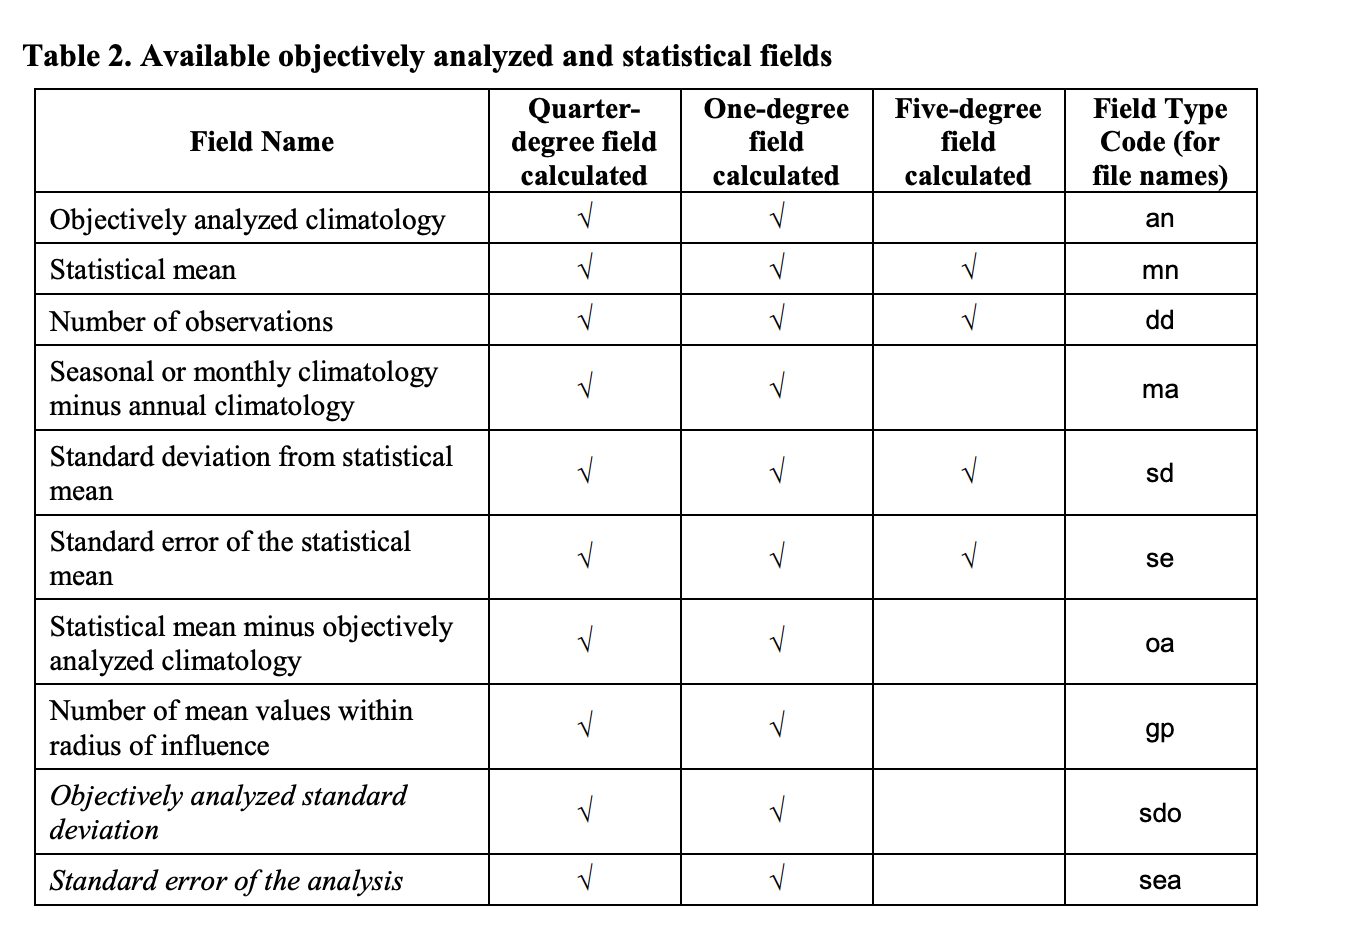